In [ ]:
import matplotlib as mpl
from matplotlib.pyplot import *
#from fm import *
import time
import pickle
from scipy import constants
import numpy as np
from matplotlib.pyplot import cm
import pdb
from numba import jit
import math
import numpy as np
import scipy as sp
from array import *
from scipy import interpolate
from scipy import special
from scipy import interp
from scipy import ndimage
from astropy.io import fits
import pdb
import datetime
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
import matplotlib.pyplot as plt

In [ ]:
# def airtovac(wlnm):
#     #Convert wavelengths (nm) in air to wavelengths in vaccuum (empirical).
#     wlA = wlnm*10.0
#     s = 1e4 / wlA
#     n = 1 + (0.00008336624212083 + 0.02408926869968 / (130.1065924522 - s**2) +
#     0.0001599740894897 / (38.92568793293 - s**2))
#     return wlA * n / 10.0
# data_dir = './reference_data/observations/WASP-121b'
# import h5py
# import numpy as np
# with h5py.File(data_dir+'/MyFinalExt_WASP-121_t1_2016-12-26.h5', 'r') as F:
#     # Note that doppler.Eldin_AirToVacuum converts from air to vacuum wavelength - let me know if you want the code.
#     wl_grid = airtovac(F['blaze/blue/wl'][:])

In [ ]:
# data_dir = './reference_data/observations/WASP-121b'
# al = np.load(data_dir+'/aligned_C_arrays.npz')
# wl_grid, _ = pickle.load(open(data_dir+'/PCA_matrix.pic', 'rb'))
# data, Ce = al['aligned/blue/C'], al['aligned/blue/Ce'] # etc, replace blue with redl/redu
# Ndet, Nphi, Npix = data.shape #yup, this again--Norders x Nphases x Npixels

In [ ]:
# data_norm = np.zeros(data.shape)
# for i in range(len(data)):
#     order = data[i]
#     order_norm = (order.T / np.median(order, axis=1)).T
#     data_norm[i] = order_norm
# data = data_norm

In [ ]:
# #SVD/PCA method-----------------------------------

# data_arr1=np.zeros(data.shape)
# data_arr=np.zeros(data.shape)

# NPC=4 #change the "4" to whatever. This is the number of PC's to remove

# for i in range(Ndet):
#     #taking only first four vectors, reconstructiong, and saving
#     u,s,vh=np.linalg.svd(data[i,],full_matrices=False)  #decompose
#     s[NPC:]=0.  
#     W=np.diag(s)
#     A=np.dot(u,np.dot(W,vh))
#     data_arr1[i,]=A

#     #removing first four vectors...this is the 'processesed data'
#     u,s,vh=np.linalg.svd(data[i,],full_matrices=False)  #decompose--not sure why I did it again....guess you don't really need this line
#     s[0:NPC]=0.
#     W=np.diag(s)
#     A=np.dot(u,np.dot(W,vh))
#     #sigma clipping sort of--it really doesn't make a yuge difference.
#     #'''
#     sig=np.std(A)
#     med=np.median(A)
#     loc=np.where(A > 3.*sig+med)
#     A[loc]=0#*0.+20*sig
#     loc=np.where(A < -3.*sig+med)
#     A[loc]=0#*0.+20*sig
    
#     data_arr[i,]=A

In [ ]:
# #saving pickles--these are used in the retrieval/log-likelihood/CCF analysis
# pickle.dump([wl_grid,data_arr1],open(data_dir+'/data_to_scale_with.pic','wb')) #this is all the telluric crud you removed. Will be used for model injection
# pickle.dump([wl_grid,data_arr],open(data_dir+'/PCA_matrix.pic','wb'))  #this is the "PCA'd" cube. It just looks like noise. The planet is in there somewhere...; wavelength might need /1000 if in A

In [ ]:
import dill
data_dir = './reference_data/observations/WASP-121b'
pl_dat = dill.load(open('{}/planet_info_py3.dill'.format(data_dir),'rb'))
p_vel1 = pl_dat['p_vel1']   # planet velocity for transit 1 (transit 2 exists but is low quality)
tmodel1 = pl_dat['tmodel1'] # transit model, used for weighting
bv1 = pl_dat['bv1']         # barycentric correction
ph1 = pl_dat['ph1']         # orbital phase
bv1 = bv1/1000
ph1 = ph1
pickle.dump(bv1, open(data_dir+'/rvel.pic','wb'))  #the Vbary+Vsys now saved as one happy array pickle
pickle.dump(ph1, open(data_dir+'/ph.pic','wb'))  #the Vbary+Vsys now saved as one happy array pickle

In [ ]:
pl_dat.keys()

In [ ]:
tmodel1 = pl_dat['tmodel1']
pickle.dump(tmodel1, open(data_dir+'/tmodel1.pic','wb'))

In [ ]:
# from POSEIDON.high_res import make_data_cube
# data_dir = './reference_data/observations/WASP-77Ab_injection_test'
# wl_grid, data = pickle.load(open(data_dir+'/data_RAW.pic', 'rb'))
# print(data.shape)
# data_scale, data_arr = make_data_cube(data, wl_grid)

# #saving pickles--these are used in the retrieval/log-likelihood/CCF analysis
# pickle.dump([wl_grid, data_scale],open(data_dir+'/data_to_scale_with.pic','wb')) #this is all the telluric crud you removed. Will be used for model injection
# pickle.dump([wl_grid, data_arr],open(data_dir+'/PCA_matrix.pic','wb'))  #this is the "PCA'd" cube. It just looks like noise. The planet is in there somewhere...; wavelength might need /1000 if in A

In [225]:
from POSEIDON.utility import read_high_res_data
from POSEIDON.high_res import fit_uncertainties
import numpy as np
data_dir = './reference_data/observations/WASP-121b'
data = read_high_res_data(data_dir, high_res='sysrem')
data_raw = data['data_raw']
Ndet, Nphi, Npix = data_raw.shape
data_raw[data_raw < 0] = 0
mask = data_raw == 0
uncertainties = fit_uncertainties(data_raw, NPC=5)
uncertainties[mask] = 1e7

In [226]:
uncertainties

array([[[1.79913312e+01, 1.79319739e+01, 1.78962962e+01, ...,
         1.68492245e+01, 1.68492258e+01, 1.68492265e+01],
        [1.78323635e+01, 1.78845726e+01, 1.78582840e+01, ...,
         1.69535503e+01, 1.69535519e+01, 1.69535528e+01],
        [1.78473779e+01, 1.78930043e+01, 1.78042717e+01, ...,
         1.68711731e+01, 1.68711747e+01, 1.68711755e+01],
        ...,
        [1.79795487e+01, 1.77893716e+01, 1.77924115e+01, ...,
         1.72451344e+01, 1.72451265e+01, 1.72451225e+01],
        [1.82706247e+01, 1.79342004e+01, 1.78110483e+01, ...,
         1.62777785e+01, 1.62777756e+01, 1.62777741e+01],
        [1.78585911e+01, 1.77056261e+01, 1.77906000e+01, ...,
         1.67221201e+01, 1.67221142e+01, 1.67221112e+01]],

       [[1.92014765e+01, 1.92523023e+01, 1.91076657e+01, ...,
         1.75626262e+01, 1.75626268e+01, 1.75626270e+01],
        [1.89856595e+01, 1.91810267e+01, 1.90936917e+01, ...,
         1.75725862e+01, 1.75725869e+01, 1.75725873e+01],
        [1.90286543e+01, 

In [227]:
pickle.dump(uncertainties, open('./reference_data/observations/WASP-121b/uncertainties.pic', 'wb'))

In [ ]:
# Gibsons 2020 remove outliers

# data_removed = np.zeros(data_raw.shape)
# for i in range(Ndet):
#     data_removed[i] = data_raw[i] - np.outer(np.median(data_raw[i], 1), np.median(data_raw[i], 0)) / np.mean(data_raw)

# for i in range(Ndet):
#     for j in range(Nphi):
#         p = np.polyfit(np.arange(len(data_removed[i][j])), data_removed[i][j], 10)
#         fit = np.polyval(p, np.arange(len(data_removed[i][j])))
#         std = data_removed[i][j].std()
#         residual = data_removed[i][j]-data_removed[i][j].mean()
        
#         for k in range(Npix):
#             if residual[k] > 4*std:
#                 data_removed[i][j][k] = fit[k]
# data_final = np.zeros(data_raw.shape)
# for i in range(Ndet):
#     data_final[i] = data_removed[i] + np.outer(np.median(data_raw[i], 1), np.median(data_raw[i], 0)) / np.mean(data_raw)

In [223]:
from POSEIDON.high_res import fast_filter
data_norm = np.zeros(data_raw.shape)
for i in range(len(data_raw)):
    order = data_raw[i]
    
    median = np.median(order, axis=0)
    median[median == 0] = np.mean(median)
    order_norm = (order / median)

    uncertainty = uncertainties[i]

    uncertainty_norm = (uncertainty / median)
    
    uncertainties[i] = uncertainty_norm
    data_norm[i] = order_norm

residuals, Us = fast_filter(data_norm, uncertainties, iter=15)

In [ ]:
Bs = np.zeros((Ndet, Nphi, Nphi))

for j in range(Ndet):
    U = Us[j]
    L = np.diag(1 / np.mean(uncertainties[j], axis=-1))
    
    # B = U @ np.linalg.inv((L @ U).T @ (L @ U)) @ (L @ U).T @ L
    B = U @ np.linalg.pinv(L @ U) @ L
    Bs[j] = B

In [ ]:
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import fast_filter, log_likelihood_sysrem, get_rot_kernel, fit_uncertainties
import math, os
import numpy as np
import pickle
import pickle
from scipy import constants
from numba import jit
from astropy.io import fits
from scipy import interpolate
from POSEIDON.core import create_star, create_planet, define_model, make_atmosphere, read_opacities, wl_grid_constant_R, wl_grid_line_by_line, compute_spectrum
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocessing import Pool
import time

R_s = 1.458*R_Sun     # Stellar radius (m)
T_s = 6776            # Stellar effective temperature (K)
Met_s = 0.13          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.24        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, stellar_spectrum = True, stellar_grid = 'phoenix')

F_s = star['F_star']
wl_s = star['wl_star']
R_s = star['stellar_radius']


#***** Define planet properties *****#

planet_name = 'WASP-121b'  # Planet name used for plots, output files etc.

R_p = 1.753*R_J      # Planetary radius (m)
M_p = 1.157*M_J      # Mass of planet (kg)
g_p = 10**(2.97-2) # Gravitational field of planet (m/s^2)
T_eq = 2450          # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass = M_p, gravity = g_p, T_eq = T_eq)

# If distance not specified, use fiducial value
if (planet['system_distance'] is None):
    planet['system_distance'] = 1    # This value only used for flux ratios, so it cancels
d = planet['system_distance']

#***** Define model *****#

model_name = 'High-res retrieval'  # Model name used for plots, output files etc.

bulk_species = ['H2', 'He']     # H2 + He comprises the bulk atmosphere
param_species = ['Fe']  # H2O, CO as in Brogi & Line

# Create the model object
model = define_model(model_name, bulk_species, param_species,
                    PT_profile = 'Madhu', high_res = 'sysrem', R_p_ref_enabled=False)

# Check the free parameters defining this model
print("Free parameters: " + str(model['param_names']))
                            

#***** Wavelength grid *****#

wl_min = 3.7      # Minimum wavelength (um)
wl_max = 5.1      # Maximum wavelength (um)
R = 200000        # Spectral resolution of grid

# wl = wl_grid_line_by_line(wl_min, wl_max)
wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 2000     # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 4500    # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20     # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.5    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step),
                    log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

# Specify the pressure grid of the atmosphere
P_min = 1.0e-5    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-5   # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure


params = (-3, 2, 1, -2.5, -1.5, 1, 3000)
log_Fe, a1, a2, log_P1, log_P2, log_P3, T_ref = params

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array([a1, a2, log_P1, log_P2, log_P3, T_ref])     # a1, a2, log_P1, log_P2, log_P3, T_deep
log_X_params = np.array([[log_Fe]])

atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, log_X_params)

# Generate planet surface flux
spectrum = compute_spectrum(planet, star, model, atmosphere, opac, wl, spectrum_type='transmission')
# spectrum *= (R_p / R_s) ** 2

In [ ]:
wl_grid = data['wl_grid']

In [ ]:
cs_p = interpolate.splrep(wl, spectrum, s=0.0)

In [245]:
V_sys = 0
K_p = 200
dPhi = 0
Phi = data['Phi']
RV_p = V_sys + K_p * np.sin(2 * np.pi * (Phi + dPhi))  # V_sys is an additive term around zero
dl_p = RV_p * 1e3 / constants.c # delta lambda, for shifting

# Looping through each order and computing total log-L by summing logLs for each obvservation/order
j = 15
wl_slice = wl_grid[j]                    # Cropped wavelengths
models_shifted = np.zeros((Nphi, Npix))  # "shifted" model spectra array at each phase
for i in range(Nphi):
    wl_shifted_p = wl_slice * (1.0 - dl_p[i])
    # wl_shifted_p = wl_slice * np.sqrt((1.0 - dl_p[i]) / (1 + dl_p[i]))
    Fp = interpolate.splev(wl_shifted_p, cs_p, der=0)
    # models_shifted[i] = (1-tmodel1[i])*(-Fp) + 1
    models_shifted[i] = ((1-tmodel1[i])/np.max(1-tmodel1))*(-Fp) + 1

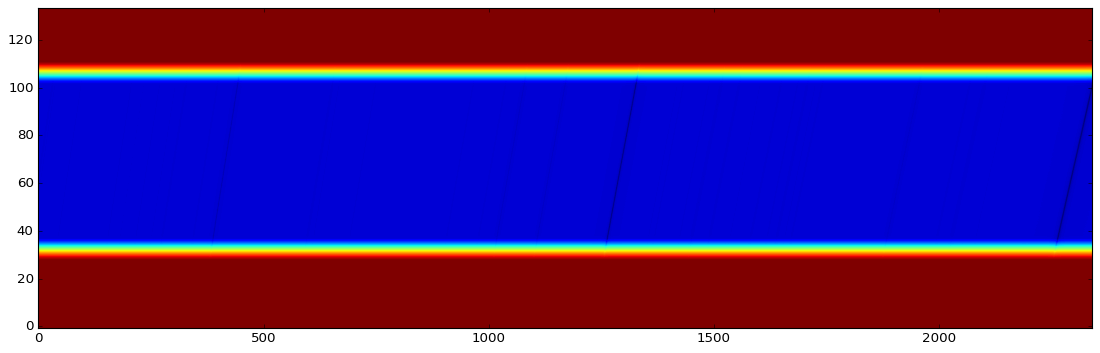

In [246]:
output_path = './CC_output/WASP-121b/'
plt.figure(figsize=(17,5))
plt.imshow(models_shifted, aspect='auto', origin='lower')
plt.savefig(output_path+'shifted_model.pdf', fmt='pdf')

In [230]:
models_shifted = (models_shifted.T / np.median(models_shifted, axis=1)).T
B = Bs[j]
model_filtered = models_shifted - B @ models_shifted

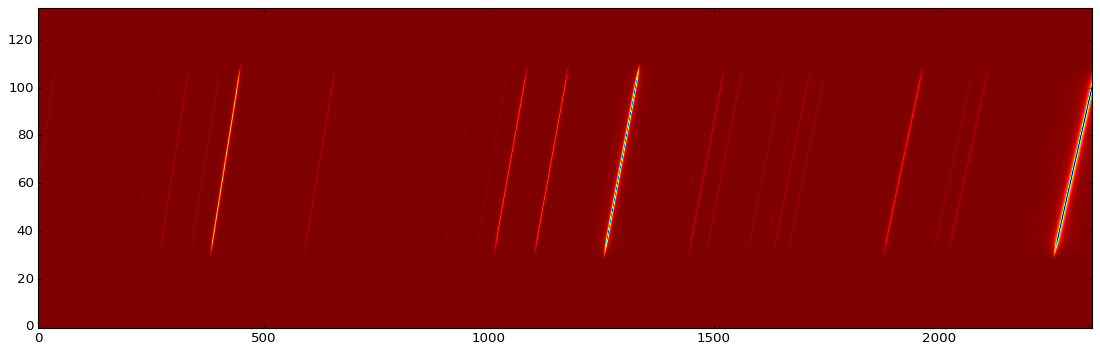

In [231]:
plt.figure(figsize=(17,5))
plt.imshow(models_shifted, aspect='auto', origin='lower')
plt.savefig(output_path+'shifted_model_normalized.pdf', fmt='pdf')

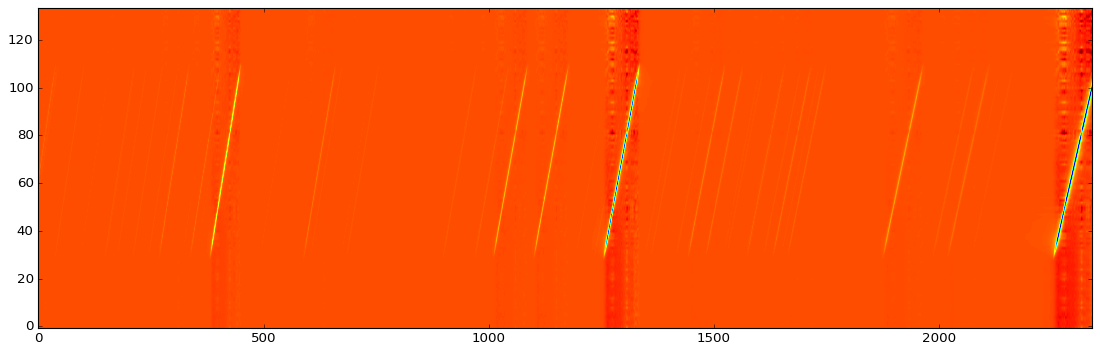

In [232]:
plt.figure(figsize=(17,5))
plt.imshow(model_filtered, aspect='auto', origin='lower')
plt.savefig(output_path+'shifted_model_filtered.pdf', fmt='pdf')
# 如果不加入constant 1 basis vector会出现五彩斑斓，因为data经过preprocessing在time direction上数量级不变，basis vector主要account for continuum; 有1让basis vectors span数量级

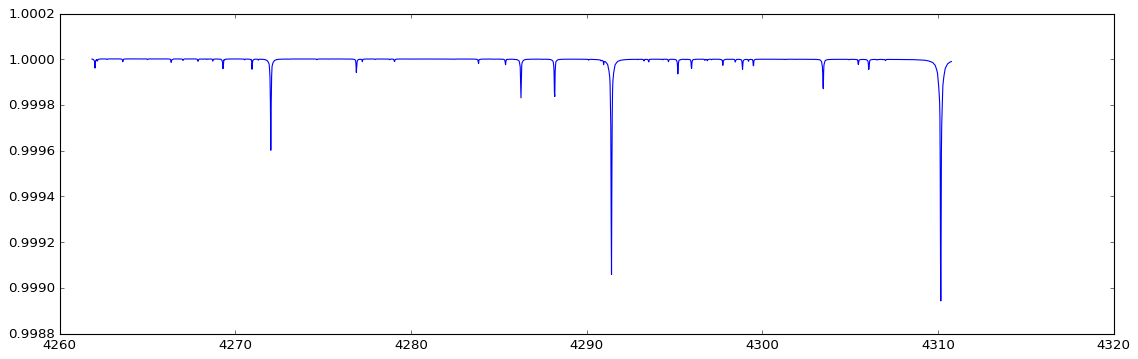

In [233]:
plt.figure(figsize=(17,5))
plt.plot(wl_grid[j]*1000, models_shifted[70])
plt.ticklabel_format(useOffset=False)
plt.savefig(output_path+'shifted_model_0_50.pdf', fmt='pdf')

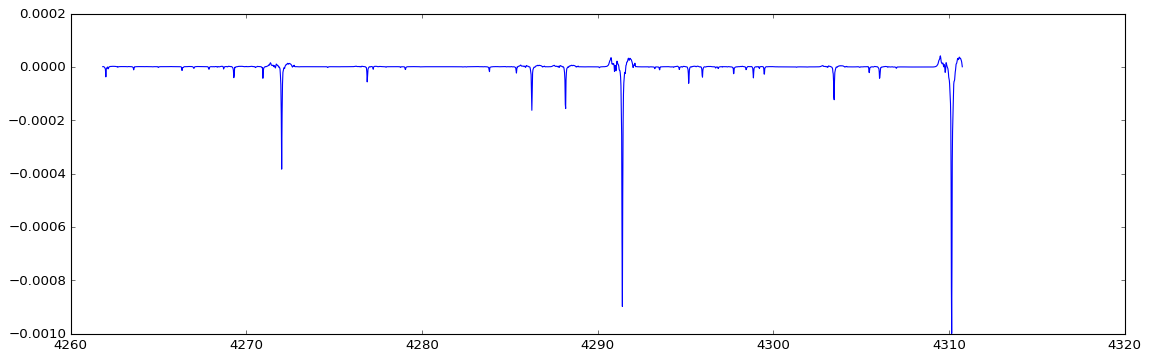

In [234]:
plt.figure(figsize=(17,5))
plt.plot(wl_grid[j]*1000, model_filtered[70])
plt.ticklabel_format(useOffset=False)
plt.savefig(output_path+'filtered_model_0_50.pdf', fmt='pdf')

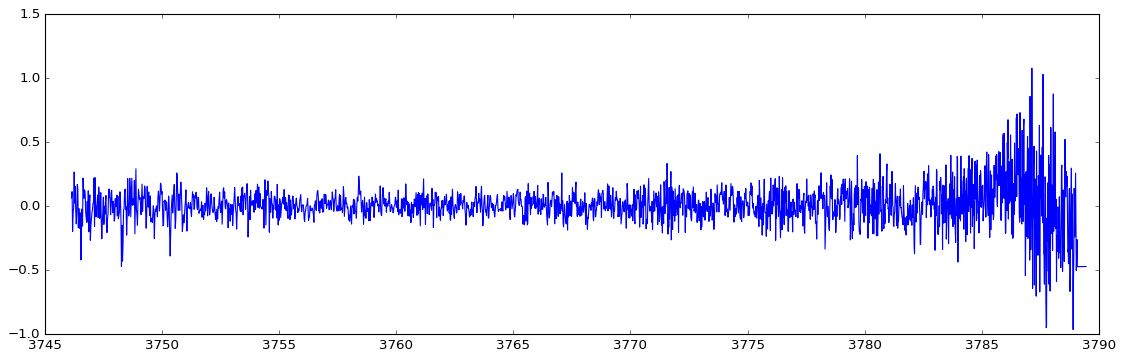

In [235]:
plt.figure(figsize=(17,5))
plt.plot(wl_grid[0]*1000, residuals[0][70])
plt.ticklabel_format(useOffset=False)
plt.savefig(output_path+'residuals_0_50.pdf', fmt='pdf')